## Obtain monthly T200 along 15°C isotherm using EN4

In [1]:
import xarray as xr
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib import cm

In [2]:
USER = os.environ['USER']

In [3]:
# EN4 T200: 1954.01-2024.11
path = f'/glade/work/{USER}/MAPP/CMEMS/DATA'
filename = f'{path}/EN4_T200_monthly_1954-2024.nc'
ds = xr.open_dataset(filename)
T200_EN4 = ds['T200'][:(2024-1954)*12+11, :, :].values # nmon,nlat,nlon
lat_EN4 = ds['lat'][:].values
lon_EN4 = ds['lon'][:].values
ds.close()

In [4]:
# calculate climatological mean T200 from 1954.01 to 2017.12
T200_EN4_mean = T200_EN4[:(2018-1954)*12, :, :].mean(axis=0) # nlat,nlon
# select grid points between 74° and 55° W
loc1 = np.where(np.abs(lon_EN4 - (-74)) < 1e-2)[0][0]
loc2 = np.where(np.abs(lon_EN4 - (-55)) < 1e-1)[0][0]
po_lon = lon_EN4[loc1:loc2+1]
print(po_lon)

[-74. -73. -72. -71. -70. -69. -68. -67. -66. -65. -64. -63. -62. -61.
 -60. -59. -58. -57. -56. -55.]


/glade/u/home/czhuomin/.local/lib/python3.7/site-packages/numpy/core/_methods.py:179: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


In [5]:
# plot the 15°C isotherm at 200-m depth
dlon, dlat = np.meshgrid(lon_EN4, lat_EN4)
plt.contourf(dlon, dlat, T200_EN4_mean, np.arange(4, 25, 0.5), cmap=cm.jet)
ch = plt.contour(dlon, dlat, T200_EN4_mean, [15])
segs = ch.allsegs[0]
newseg = segs[0]
newseg = newseg[::-1]
plt.close()

In [6]:
# Etopo data
path = f'/glade/work/{USER}/MAPP/ETOPO'
#filename = f'{path}/Etopo1_Bed_0_65N_170E_40W.nc'
filename = f'{path}/Etopo1_Bed_35_65N_40_80W.nc'
bathy = xr.open_dataset(filename)
lon_e = bathy['lon']
for ii in range(len(lon_e)):
    if lon_e[ii]>0:
        lon_e[ii] = lon_e[ii] - 360.
lat_e = bathy['lat'][:]
depth_e = bathy['depth'][:,:]
bathy.close()
#
mask_bathy = (depth_e >= 0.)*1.
mask_bathy = np.ma.array(mask_bathy,mask=mask_bathy==0.)
lon_e,lat_e = np.meshgrid(lon_e,lat_e)
lon_e = np.ma.array(lon_e,mask=~mask_bathy.mask)
lat_e = np.ma.array(lat_e,mask=~mask_bathy.mask)
depth_e1 = -np.ma.array(depth_e,mask=~mask_bathy.mask)

/glade/u/home/czhuomin/.conda/envs/fish-offline/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  del sys.path[0]


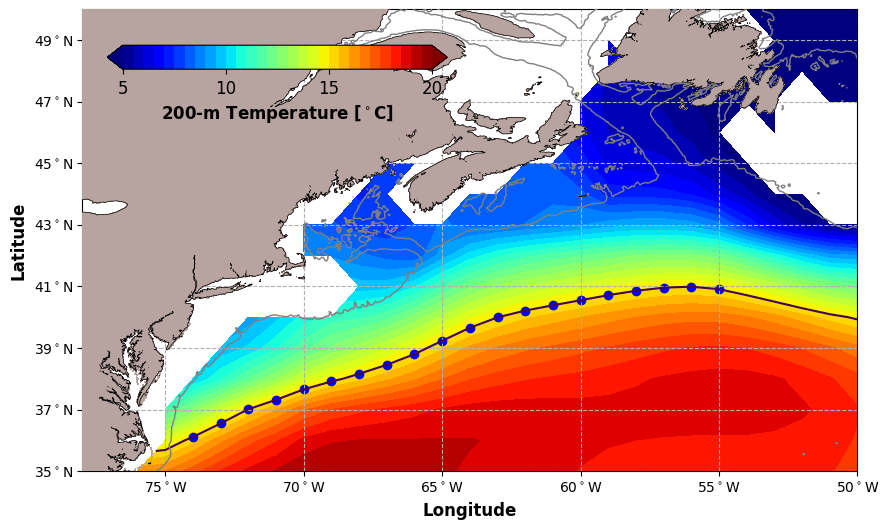

In [7]:
loc = []
for hh in range(len(po_lon)):
    ll = np.where(np.abs(newseg[:,0] - po_lon[hh]) < 1e-4)[0][0]
    loc.append(ll)
#
newseg = newseg[loc]
po_lon = newseg[:,0]
po_lat = newseg[:,1]
#
fig = plt.figure(figsize=[10,6])
ax = fig.add_subplot(111)
# plot continent/bathymetry
ax.pcolor(lon_e,lat_e,mask_bathy,shading='nearest',cmap=cm.terrain_r,vmin=.5,vmax=4,zorder=20)
# plot coastal lines
ax.contour(lon_e,lat_e,depth_e,[0],colors='k',linestyles='solid',linewidths=.5,zorder=21)
# plot 200-m isobaths
ax.contour(lon_e,lat_e,depth_e,[-200],colors='gray',linestyles='solid',linewidths=1.,zorder=21)
#
cd = plt.contourf(dlon, dlat, T200_EN4_mean, np.arange(5, 20.3, 0.5), cmap=cm.jet, extend='both')
ch = plt.contour(dlon, dlat, T200_EN4_mean, [15])
plt.scatter(po_lon, po_lat, color='b', marker='o')
#
ax.set_xticks(np.arange(-75,-49,5))
ax.set_xticklabels([r'%d$^\circ$W' % -ii for ii in np.arange(-75,-49,5)])
ax.set_yticks(np.arange(35,51,2))
ax.set_yticklabels([r'%d$^\circ$N' % ii for ii in np.arange(35,51,2)])
plt.ylabel('Latitude',fontsize=12,fontweight='bold')
plt.xlabel('Longitude',fontsize=12,fontweight='bold')
plt.xlim(-78,-50)
plt.ylim(35,50)
plt.grid(linestyle='dashed')
# colorbar
cbaxes = fig.add_axes([0.15, 0.78, 0.34, 0.04])
cb = plt.colorbar(cd,orientation="horizontal",cax=cbaxes,ticks=range(5,21,5))
cb.ax.tick_params(labelsize=12)
cb.set_label(label=r"200-m Temperature [$^\circ$C]",fontsize=12,fontweight='bold')
## save fig
output = f'/glade/work/{USER}/MAPP/CMEMS/PLOTS'
outfile = '%s/T200-based_GSI_74-55W_195401-202411_monthly_points.png' % (output)
plt.savefig(outfile, dpi=400, facecolor='w', edgecolor='w', orientation='portrait')
#
plt.show()

In [8]:
# save to file
dsf = xr.Dataset()
dsf['po_lon'] = po_lon
dsf['po_lat'] = po_lat
dsf.load()

<xarray.Dataset>
Dimensions:  (po_lon: 20, po_lat: 20)
Coordinates:
  * po_lon   (po_lon) float64 -74.0 -73.0 -72.0 -71.0 ... -57.0 -56.0 -55.0
  * po_lat   (po_lat) float64 36.11 36.55 37.01 37.32 ... 40.96 40.99 40.91
Data variables:
    *empty*

In [9]:
outpath = f'/glade/work/{USER}/MAPP/CMEMS/DATA'
dsf.to_netcdf(f'{outpath}/EN4_T200_15_degC_lon_lat.nc', mode='w')

### obtain the selected points' T200 time series

In [10]:
T_po = np.ma.zeros([len(po_lon), np.shape(T200_EN4)[0]]); T_po.mask = True
for ii in range(len(po_lon)):
    loni = np.where(lon_EN4 == po_lon[ii])[0][0]
    lati = np.where(lat_EN4 == np.floor(po_lat[ii]))[0][0]
    #
    T_po[ii, :] = T200_EN4[:, lati, loni] + (po_lat[ii]-np.floor(po_lat[ii]))*(T200_EN4[:,lati+1,loni]-T200_EN4[:,lati,loni])/(np.ceil(po_lat[ii])-np.floor(po_lat[ii]))

In [11]:
# remove seasonal climatology
T_po_c = T_po[:, :(2018-1954)*12].reshape([len(po_lon), 2018-1954, 12]).mean(axis=1) # 1954-2018
T_po_c = np.tile(T_po_c[:, np.newaxis, :], [1, 2025-1954, 1]).reshape([len(po_lon), (2025-1954)*12])
T_po = T_po - T_po_c[:, :np.shape(T200_EN4)[0]]

In [12]:
# save to file
dsf = xr.Dataset()
dsf['T_po'] = xr.DataArray(data=T_po, coords=dict(npo=('npo', range(len(po_lon))), nmon=('nmon',range(np.shape(T200_EN4)[0]))),dims=('npo','nmon'))
dsf['po_lon'] = po_lon
dsf['po_lat'] = po_lat
dsf.load()
outpath = f'/glade/work/{USER}/MAPP/CMEMS/DATA'
dsf.to_netcdf(f'{outpath}/EN4_20points_T200_time_series_195401-202411.nc', mode='w')